In [1]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, random_split, DataLoader, SubsetRandomSampler, ConcatDataset
from torch import nn
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Some predefine variable for different path

# Modify below variable according to your need
dataset_path = "drive/MyDrive/COMP6721_project/AI" # This contains path to the actual dataset
model_path = "./model.pth" # This contains path to the actual model
test_image_path = r"drive/MyDrive/COMP6721_project/test_image" # This contains path for images to test, don't remove 'r'
# dataset_path = "E:\Concordia\Winter2022\COMP6721-AI\Assignments\Project\project part 1\project\dataset" # This contains path to the actual dataset
# model_path = "E:\Concordia\Winter2022\COMP6721-AI\Assignments\Project\project part 1\project\model\model.pth" # This contains path to the actual model
# test_image_path = r"E:\Concordia\Winter2022\COMP6721-AI\Assignments\Project\project part 1\project\test_image" # This contains path for images to test, don't remove 'r'

In [4]:
dataset = ImageFolder(dataset_path)
print(f'number of images: {len(dataset)}')
print(f'number of classes: {len(dataset.classes)}')
target_names = dataset.classes
print(target_names)

number of images: 2026
number of classes: 5
['Cloth mask', 'N-95 mask with valve', 'N-95_Mask', 'No Face Mask', 'Surgical Mask']


In [5]:
# Here we are splitting our dataset into 1500 training and 500 testing images
test_pct = 0.25
test_size = int(len(dataset)*test_pct)
train_size = len(dataset) - test_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])
valid_pct = 0.10
valid_size = int(len(train_ds)*valid_pct)
train_size = train_size - valid_size
train_ds, valid_ds = random_split(train_ds,[train_size,valid_size])


In [6]:
class FaceMaskDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [52]:
batch_size = 15

train_transform = transforms.Compose([
        transforms.Resize((96,96)),
        transforms.ToTensor(),
    ])

test_transform = transforms.Compose([
        transforms.Resize((96,96)),
        transforms.ToTensor()
    ])

train_dataset = FaceMaskDataset(train_ds, train_transform)
valid_dataset = FaceMaskDataset(valid_ds, train_transform)
test_dataset = FaceMaskDataset(test_ds, test_transform)

train_dl = DataLoader(train_dataset, batch_size, shuffle=True)

valid_dl = DataLoader(valid_dataset, batch_size)
test_dl = DataLoader(test_dataset, batch_size)

In [19]:
# This method is use to train model on 1500 images we have splitted
def Train(model,optimizer,dataloader,device):
    loss_tracker = []
    Train_accuracy_tracker = []
    correct = total = 0
    for i,(data,label) in enumerate(dataloader):
        data = data.requires_grad_()
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        
        outputs= model(data)
        CE_loss = nn.CrossEntropyLoss()
        loss = CE_loss(outputs,label)
        loss.backward()  

        optimizer.step()

        
        with torch.no_grad():
                _,predicted = torch.max(outputs.data,1)
                total += label.size(0)
                correct += (predicted == label).sum().item()
                accuracy = (correct/total)*100
        loss_tracker.append(loss.item())
        Train_accuracy_tracker.append(accuracy)

    return loss_tracker, Train_accuracy_tracker

# Here we will test our input images and 500 testing images
def Test(model,dataloader,device):
    loss_tracker = []
    Test_accuracy_tracker = []
    total = correct = 0
    predict = []
    labels = []
    for i,(data,label) in enumerate(dataloader):
        data = data.to(device)
        label.to(device)
        labels.extend(label)
        with torch.no_grad():
         
            output = model(data)
            CE_loss = nn.CrossEntropyLoss()
            loss = CE_loss(output,label)
            _,predicted = torch.max(output.data,1)
            predict.extend(predicted)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            accuracy = (correct/total)*100
            
        loss_tracker.append(loss.item())
        Test_accuracy_tracker.append(accuracy)
        
    return sum(loss_tracker)/len(loss_tracker), sum(Test_accuracy_tracker)/len(Test_accuracy_tracker), labels, predict
        

In [40]:
class conv_net(nn.Module):
    def __init__(self):
        super(conv_net,self).__init__()
        self.network = nn.Sequential(
                                      nn.Conv2d(3, 16, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3),
                                     
                                      nn.Conv2d(16, 32, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2),
                                     
                                      nn.Conv2d(32, 64, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3),
                                     
                                      nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2),
                                      
                                      nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2),
                                      
                                      nn.Flatten(),
                                      nn.Linear(256, 1024),
                                      nn.Linear(1024, 64),
                                      nn.Linear(64, 5),
                                      nn.Softmax(1)


                                    )
        
    
    def forward(self,x):
        x = x.to(device)
        return self.network(x)

In [10]:
device = "cpu"

device: cpu
Fold 1
epoch: 0


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	 training loss/accuracy: 1.61/20.00
	 validation loss/accuracy: 1.61/24.99
epoch: 1
	 training loss/accuracy: 1.54/31.33
	 validation loss/accuracy: 1.53/23.62
epoch: 2
	 training loss/accuracy: 1.48/33.92
	 validation loss/accuracy: 1.43/44.01
epoch: 3
	 training loss/accuracy: 1.44/43.87
	 validation loss/accuracy: 1.39/48.35
epoch: 4
	 training loss/accuracy: 1.42/42.79
	 validation loss/accuracy: 1.37/50.50
epoch: 5
	 training loss/accuracy: 1.39/45.32
	 validation loss/accuracy: 1.37/53.03
epoch: 6
	 training loss/accuracy: 1.39/49.47
	 validation loss/accuracy: 1.36/47.18
epoch: 7
	 training loss/accuracy: 1.38/50.44
	 validation loss/accuracy: 1.33/52.82
epoch: 8
	 training loss/accuracy: 1.37/51.65
	 validation loss/accuracy: 1.33/56.36
epoch: 9
	 training loss/accuracy: 1.36/53.70
	 validation loss/accuracy: 1.31/59.65
epoch: 10
	 training loss/accuracy: 1.33/57.59
	 validation loss/accuracy: 1.31/56.35
epoch: 11
	 training loss/accuracy: 1.34/53.26
	 validation loss/accuracy

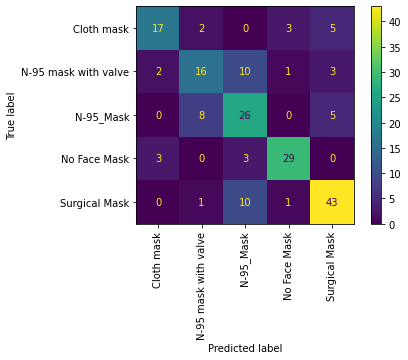

device: cpu
Fold 2
epoch: 0


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	 training loss/accuracy: 1.61/21.34
	 validation loss/accuracy: 1.60/22.42
epoch: 1
	 training loss/accuracy: 1.54/31.15
	 validation loss/accuracy: 1.51/31.98
epoch: 2
	 training loss/accuracy: 1.49/34.96
	 validation loss/accuracy: 1.49/37.09
epoch: 3
	 training loss/accuracy: 1.47/38.16
	 validation loss/accuracy: 1.46/41.80
epoch: 4
	 training loss/accuracy: 1.42/45.15
	 validation loss/accuracy: 1.42/42.91
epoch: 5
	 training loss/accuracy: 1.40/44.76
	 validation loss/accuracy: 1.38/47.22
epoch: 6
	 training loss/accuracy: 1.38/50.31
	 validation loss/accuracy: 1.47/35.55
epoch: 7
	 training loss/accuracy: 1.34/53.33
	 validation loss/accuracy: 1.34/60.74
epoch: 8
	 training loss/accuracy: 1.32/58.11
	 validation loss/accuracy: 1.34/51.94
epoch: 9
	 training loss/accuracy: 1.28/61.16
	 validation loss/accuracy: 1.30/61.94
epoch: 10
	 training loss/accuracy: 1.28/61.40
	 validation loss/accuracy: 1.30/59.34
epoch: 11
	 training loss/accuracy: 1.24/63.58
	 validation loss/accuracy

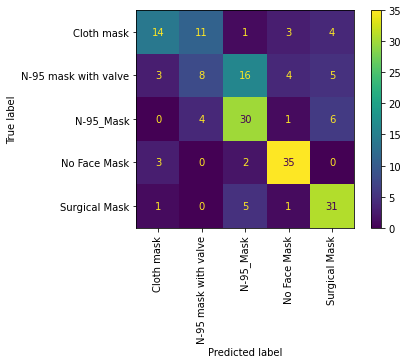

device: cpu
Fold 3
epoch: 0


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	 training loss/accuracy: 1.61/22.31
	 validation loss/accuracy: 1.60/34.02
epoch: 1
	 training loss/accuracy: 1.56/27.23
	 validation loss/accuracy: 1.51/29.52
epoch: 2
	 training loss/accuracy: 1.49/34.11
	 validation loss/accuracy: 1.46/36.15
epoch: 3
	 training loss/accuracy: 1.44/41.80
	 validation loss/accuracy: 1.42/52.63
epoch: 4
	 training loss/accuracy: 1.40/48.80
	 validation loss/accuracy: 1.40/49.37
epoch: 5
	 training loss/accuracy: 1.38/50.23
	 validation loss/accuracy: 1.40/50.09
epoch: 6
	 training loss/accuracy: 1.38/47.41
	 validation loss/accuracy: 1.34/52.76
epoch: 7
	 training loss/accuracy: 1.31/57.10
	 validation loss/accuracy: 1.33/62.16
epoch: 8
	 training loss/accuracy: 1.29/57.69
	 validation loss/accuracy: 1.32/60.60
epoch: 9
	 training loss/accuracy: 1.28/63.35
	 validation loss/accuracy: 1.30/61.74
epoch: 10
	 training loss/accuracy: 1.26/64.68
	 validation loss/accuracy: 1.30/59.57
epoch: 11
	 training loss/accuracy: 1.26/63.78
	 validation loss/accuracy

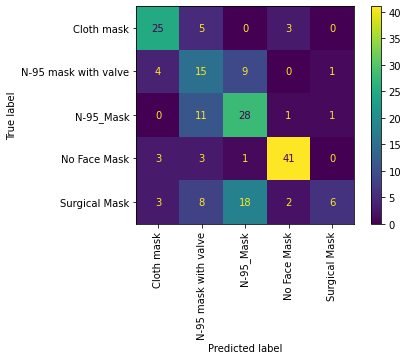

device: cpu
Fold 4
epoch: 0


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	 training loss/accuracy: 1.61/21.21
	 validation loss/accuracy: 1.59/31.67
epoch: 1
	 training loss/accuracy: 1.52/32.75
	 validation loss/accuracy: 1.52/33.54
epoch: 2
	 training loss/accuracy: 1.48/34.05
	 validation loss/accuracy: 1.49/39.29
epoch: 3
	 training loss/accuracy: 1.42/45.73
	 validation loss/accuracy: 1.47/35.39
epoch: 4
	 training loss/accuracy: 1.39/49.15
	 validation loss/accuracy: 1.46/39.54
epoch: 5
	 training loss/accuracy: 1.40/47.20
	 validation loss/accuracy: 1.45/44.34
epoch: 6
	 training loss/accuracy: 1.40/48.97
	 validation loss/accuracy: 1.45/38.64
epoch: 7
	 training loss/accuracy: 1.37/52.50
	 validation loss/accuracy: 1.52/34.32
epoch: 8
	 training loss/accuracy: 1.37/48.39
	 validation loss/accuracy: 1.44/44.84
epoch: 9
	 training loss/accuracy: 1.37/51.79
	 validation loss/accuracy: 1.42/46.96
epoch: 10
	 training loss/accuracy: 1.35/56.43
	 validation loss/accuracy: 1.41/37.97
epoch: 11
	 training loss/accuracy: 1.35/56.03
	 validation loss/accuracy

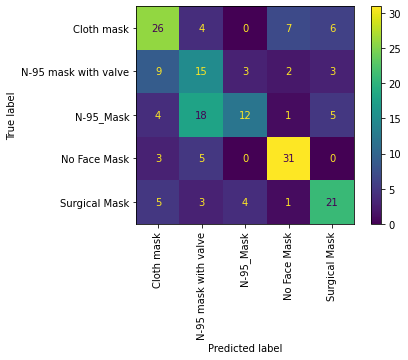

device: cpu
Fold 5
epoch: 0


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	 training loss/accuracy: 1.61/22.99
	 validation loss/accuracy: 1.60/22.58
epoch: 1
	 training loss/accuracy: 1.58/24.08
	 validation loss/accuracy: 1.50/45.17
epoch: 2
	 training loss/accuracy: 1.49/34.96
	 validation loss/accuracy: 1.41/46.01
epoch: 3
	 training loss/accuracy: 1.42/44.40
	 validation loss/accuracy: 1.35/53.23
epoch: 4
	 training loss/accuracy: 1.38/50.94
	 validation loss/accuracy: 1.34/53.12
epoch: 5
	 training loss/accuracy: 1.35/53.94
	 validation loss/accuracy: 1.32/52.66
epoch: 6
	 training loss/accuracy: 1.31/58.75
	 validation loss/accuracy: 1.29/69.05
epoch: 7
	 training loss/accuracy: 1.28/58.41
	 validation loss/accuracy: 1.29/55.72
epoch: 8
	 training loss/accuracy: 1.27/61.80
	 validation loss/accuracy: 1.29/57.86
epoch: 9
	 training loss/accuracy: 1.26/64.58
	 validation loss/accuracy: 1.27/64.13
epoch: 10
	 training loss/accuracy: 1.22/69.10
	 validation loss/accuracy: 1.31/56.76
epoch: 11
	 training loss/accuracy: 1.24/66.68
	 validation loss/accuracy

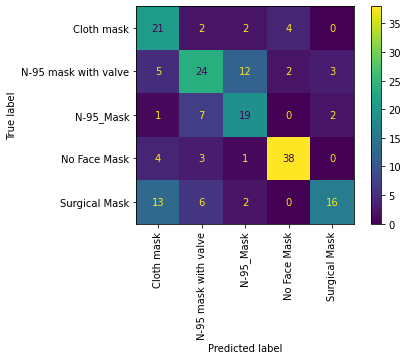

device: cpu
Fold 6
epoch: 0


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	 training loss/accuracy: 1.61/21.80
	 validation loss/accuracy: 1.61/39.61
epoch: 1
	 training loss/accuracy: 1.54/30.05
	 validation loss/accuracy: 1.46/29.60
epoch: 2
	 training loss/accuracy: 1.47/39.05
	 validation loss/accuracy: 1.40/46.76
epoch: 3
	 training loss/accuracy: 1.43/44.89
	 validation loss/accuracy: 1.37/47.67
epoch: 4
	 training loss/accuracy: 1.40/46.59
	 validation loss/accuracy: 1.37/46.55
epoch: 5
	 training loss/accuracy: 1.40/47.46
	 validation loss/accuracy: 1.35/46.08
epoch: 6
	 training loss/accuracy: 1.36/51.88
	 validation loss/accuracy: 1.43/44.85
epoch: 7
	 training loss/accuracy: 1.35/52.41
	 validation loss/accuracy: 1.38/49.53
epoch: 8
	 training loss/accuracy: 1.33/55.28
	 validation loss/accuracy: 1.34/59.04
epoch: 9
	 training loss/accuracy: 1.30/57.71
	 validation loss/accuracy: 1.27/66.32
epoch: 10
	 training loss/accuracy: 1.28/62.98
	 validation loss/accuracy: 1.24/61.49
epoch: 11
	 training loss/accuracy: 1.24/65.48
	 validation loss/accuracy

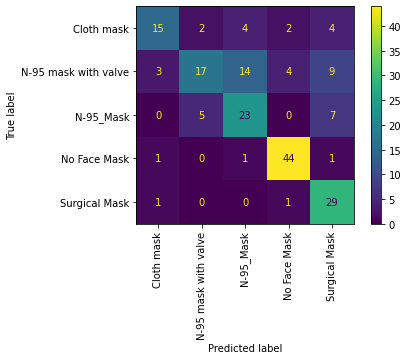

device: cpu
Fold 7
epoch: 0


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	 training loss/accuracy: 1.61/21.30
	 validation loss/accuracy: 1.61/23.04
epoch: 1
	 training loss/accuracy: 1.56/29.33
	 validation loss/accuracy: 1.51/38.32
epoch: 2
	 training loss/accuracy: 1.50/36.73
	 validation loss/accuracy: 1.50/29.98
epoch: 3
	 training loss/accuracy: 1.46/39.07
	 validation loss/accuracy: 1.51/36.30
epoch: 4
	 training loss/accuracy: 1.43/43.08
	 validation loss/accuracy: 1.45/44.53
epoch: 5
	 training loss/accuracy: 1.40/47.77
	 validation loss/accuracy: 1.46/37.88
epoch: 6
	 training loss/accuracy: 1.39/49.22
	 validation loss/accuracy: 1.46/39.77
epoch: 7
	 training loss/accuracy: 1.38/49.33
	 validation loss/accuracy: 1.44/39.87
epoch: 8
	 training loss/accuracy: 1.34/52.43
	 validation loss/accuracy: 1.37/52.19
epoch: 9
	 training loss/accuracy: 1.31/60.73
	 validation loss/accuracy: 1.39/51.03
epoch: 10
	 training loss/accuracy: 1.27/60.35
	 validation loss/accuracy: 1.33/55.63
epoch: 11
	 training loss/accuracy: 1.28/58.86
	 validation loss/accuracy

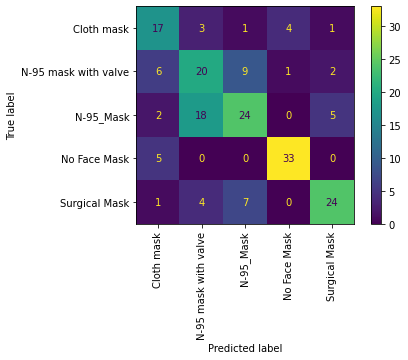

device: cpu
Fold 8
epoch: 0


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	 training loss/accuracy: 1.61/19.42
	 validation loss/accuracy: 1.61/21.97
epoch: 1
	 training loss/accuracy: 1.56/26.43
	 validation loss/accuracy: 1.50/33.76
epoch: 2
	 training loss/accuracy: 1.49/37.84
	 validation loss/accuracy: 1.45/36.57
epoch: 3
	 training loss/accuracy: 1.46/35.66
	 validation loss/accuracy: 1.40/55.91
epoch: 4
	 training loss/accuracy: 1.43/44.38
	 validation loss/accuracy: 1.44/43.96
epoch: 5
	 training loss/accuracy: 1.42/45.41
	 validation loss/accuracy: 1.37/56.02
epoch: 6
	 training loss/accuracy: 1.38/50.98
	 validation loss/accuracy: 1.35/60.16
epoch: 7
	 training loss/accuracy: 1.37/52.04
	 validation loss/accuracy: 1.47/43.71
epoch: 8
	 training loss/accuracy: 1.36/52.35
	 validation loss/accuracy: 1.39/55.24
epoch: 9
	 training loss/accuracy: 1.31/57.20
	 validation loss/accuracy: 1.29/67.05
epoch: 10
	 training loss/accuracy: 1.30/61.58
	 validation loss/accuracy: 1.33/57.12
epoch: 11
	 training loss/accuracy: 1.28/62.24
	 validation loss/accuracy

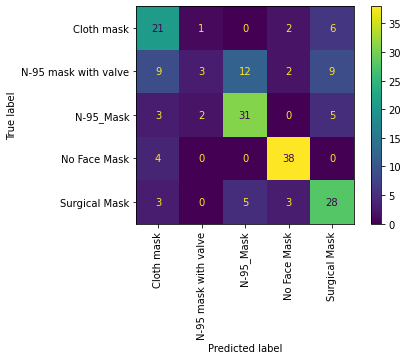

device: cpu
Fold 9
epoch: 0


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	 training loss/accuracy: 1.61/22.44
	 validation loss/accuracy: 1.61/31.90
epoch: 1
	 training loss/accuracy: 1.58/27.52
	 validation loss/accuracy: 1.53/26.30
epoch: 2
	 training loss/accuracy: 1.52/32.67
	 validation loss/accuracy: 1.51/35.05
epoch: 3
	 training loss/accuracy: 1.47/37.50
	 validation loss/accuracy: 1.49/36.65
epoch: 4
	 training loss/accuracy: 1.42/45.82
	 validation loss/accuracy: 1.46/40.54
epoch: 5
	 training loss/accuracy: 1.40/47.55
	 validation loss/accuracy: 1.43/37.55
epoch: 6
	 training loss/accuracy: 1.37/54.39
	 validation loss/accuracy: 1.40/46.48
epoch: 7
	 training loss/accuracy: 1.33/54.39
	 validation loss/accuracy: 1.37/49.59
epoch: 8
	 training loss/accuracy: 1.29/60.85
	 validation loss/accuracy: 1.37/52.05
epoch: 9
	 training loss/accuracy: 1.28/58.70
	 validation loss/accuracy: 1.31/59.26
epoch: 10
	 training loss/accuracy: 1.22/67.16
	 validation loss/accuracy: 1.34/53.80
epoch: 11
	 training loss/accuracy: 1.22/68.88
	 validation loss/accuracy

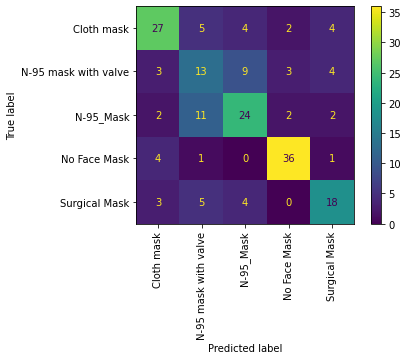

device: cpu
Fold 10
epoch: 0


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	 training loss/accuracy: 1.61/23.05
	 validation loss/accuracy: 1.60/20.25
epoch: 1
	 training loss/accuracy: 1.57/28.38
	 validation loss/accuracy: 1.47/40.88
epoch: 2
	 training loss/accuracy: 1.49/33.68
	 validation loss/accuracy: 1.41/47.63
epoch: 3
	 training loss/accuracy: 1.45/40.47
	 validation loss/accuracy: 1.40/46.43
epoch: 4
	 training loss/accuracy: 1.43/43.37
	 validation loss/accuracy: 1.38/48.63
epoch: 5
	 training loss/accuracy: 1.40/47.06
	 validation loss/accuracy: 1.39/49.27
epoch: 6
	 training loss/accuracy: 1.41/42.64
	 validation loss/accuracy: 1.36/48.80
epoch: 7
	 training loss/accuracy: 1.40/52.17
	 validation loss/accuracy: 1.34/54.54
epoch: 8
	 training loss/accuracy: 1.35/55.50
	 validation loss/accuracy: 1.33/61.91
epoch: 9
	 training loss/accuracy: 1.34/58.63
	 validation loss/accuracy: 1.32/58.33
epoch: 10
	 training loss/accuracy: 1.31/61.95
	 validation loss/accuracy: 1.32/58.29
epoch: 11
	 training loss/accuracy: 1.30/61.67
	 validation loss/accuracy

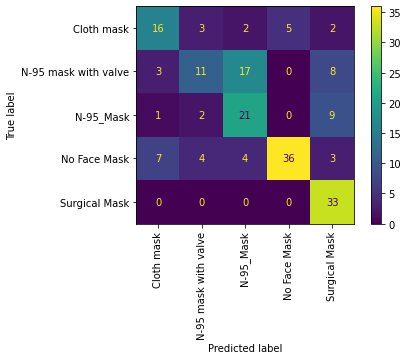

In [45]:
splits = KFold(n_splits=10, shuffle=True)

dataset_d = ConcatDataset([train_dataset, test_dataset])

overall_loss = []
overall_acuracy = []

for fold, (train_idx,val_idx) in enumerate(splits.split(torch.arange(len(dataset_d)))):
  epochs = 20
  learning_rate = 0.0005

  print(f'device: {device}')

  model = conv_net()
  model.to(device)

  optimizer = torch.optim.RAdam(model.parameters(), learning_rate)

  train_loss_tracker = []
  train_accuracy_tracker = []

  test_loss_tracker = []
  test_accuracy_tracker = []
  
  print('Fold {}'.format(fold+ 1))
  train_sampler= SubsetRandomSampler(train_idx)

  test_sampler= SubsetRandomSampler(val_idx)

  train_loader= DataLoader(dataset_d, batch_size=batch_size, sampler=train_sampler)
  valid_accuracy = 0.0
  valid_loader= DataLoader(dataset_d, batch_size=batch_size, sampler=test_sampler)
  
  for epoch in range(epochs):
    print(f'epoch: {epoch}')
    train_loss, train_accuracy = Train(model,optimizer,train_loader,device)
    valid_loss, valid_accuracy, labels, predict = Test(model,valid_loader,device)
    train_loss_tracker.extend(train_loss)
    train_accuracy_tracker.extend(train_accuracy)
    test_loss_tracker.append(valid_loss)
    test_accuracy_tracker.append(valid_accuracy)
    
    overall_loss.append(valid_loss)
    overall_acuracy.append(valid_accuracy)

    print('\t training loss/accuracy: {0:.2f}/{1:.2f}'.format(sum(train_loss)/len(train_loss), sum(train_accuracy)/len(train_accuracy)))
    print('\t validation loss/accuracy: {0:.2f}/{1:.2f}'.format(valid_loss, valid_accuracy))
  
  print(classification_report(labels, predict, target_names=target_names))
  cm = confusion_matrix(labels,predict)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
  disp.plot(xticks_rotation="vertical")
  plt.show()
  
  model_name = "model/" + str(valid_accuracy) + ".pth"
  torch.save(model, model_name)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


                      precision    recall  f1-score   support

          Cloth mask       0.92      0.67      0.77        87
N-95 mask with valve       0.80      0.64      0.71       106
           N-95_Mask       0.65      0.84      0.73        99
        No Face Mask       0.83      0.93      0.88       123
       Surgical Mask       0.78      0.80      0.79        91

            accuracy                           0.78       506
           macro avg       0.80      0.78      0.78       506
        weighted avg       0.80      0.78      0.78       506



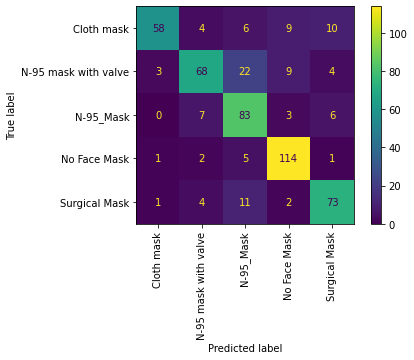

In [53]:
gen_model = torch.load(model_path)
valid_loss, valid_accuracy, labels, predict = Test(gen_model,test_dl,device)
# Classification report and Confusion matrix for testing images
print(classification_report(labels, predict, target_names=target_names))
cm = confusion_matrix(labels,predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp.plot(xticks_rotation="vertical")
plt.show()

                      precision    recall  f1-score   support

          Cloth mask       0.69      0.45      0.55        20
N-95 mask with valve       0.61      0.52      0.56        21
           N-95_Mask       0.62      0.65      0.63        20
        No Face Mask       0.77      1.00      0.87        20
       Surgical Mask       0.78      0.90      0.84        20

            accuracy                           0.70       101
           macro avg       0.69      0.70      0.69       101
        weighted avg       0.69      0.70      0.69       101



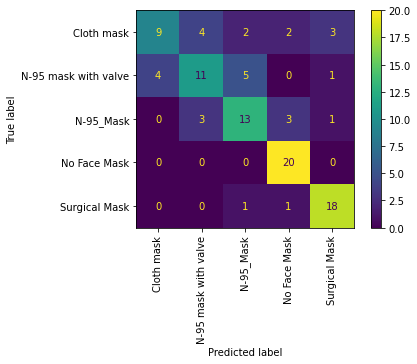

In [55]:
# Testing part for pre trained model
gen_model = torch.load(model_path)
# test_image_path = test_image_path.replace("\\","/")
test_image_path = r"drive/MyDrive/COMP6721_project/test_image/women"
image = ImageFolder(test_image_path)
test_image = FaceMaskDataset(image, test_transform)
test_data = DataLoader(test_image, 10)
test_loss , test_accuracy,l,p = Test(gen_model,test_data,device)

# Classification report and Confusion matrix for testing images
print(classification_report(l,p, target_names=target_names))
cm = confusion_matrix(l,p)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp.plot(xticks_rotation="vertical")
plt.show()

                      precision    recall  f1-score   support

          Cloth mask       0.80      0.40      0.53        20
N-95 mask with valve       0.58      0.55      0.56        20
           N-95_Mask       0.58      0.75      0.65        20
        No Face Mask       0.90      0.90      0.90        20
       Surgical Mask       0.68      0.85      0.76        20

            accuracy                           0.69       100
           macro avg       0.71      0.69      0.68       100
        weighted avg       0.71      0.69      0.68       100



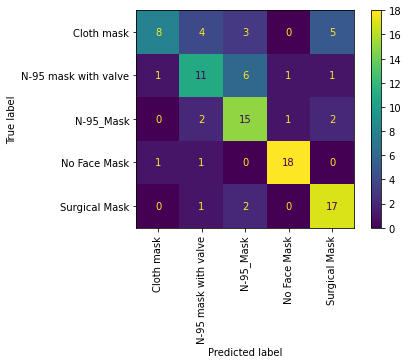

In [60]:
gen_model = torch.load(model_path)

test_image_path = r"drive/MyDrive/COMP6721_project/test_image/men"
image = ImageFolder(test_image_path)
test_image = FaceMaskDataset(image, test_transform)
test_data = DataLoader(test_image, 10)
test_loss , test_accuracy,l,p = Test(gen_model,test_data,device)

# Classification report and Confusion matrix for testing images
print(classification_report(l,p, target_names=target_names))
cm = confusion_matrix(l,p)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp.plot(xticks_rotation="vertical")
plt.show()

                      precision    recall  f1-score   support

          Cloth mask       0.62      0.50      0.56        10
N-95 mask with valve       0.56      0.50      0.53        10
           N-95_Mask       0.67      0.60      0.63        10
        No Face Mask       0.82      0.82      0.82        11
       Surgical Mask       0.57      0.80      0.67        10

            accuracy                           0.65        51
           macro avg       0.65      0.64      0.64        51
        weighted avg       0.65      0.65      0.64        51



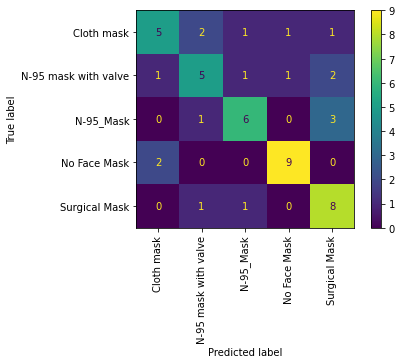

In [61]:
gen_model = torch.load(model_path)

test_image_path = r"drive/MyDrive/COMP6721_project/test_image/Asian_race"
image = ImageFolder(test_image_path)
test_image = FaceMaskDataset(image, test_transform)
test_data = DataLoader(test_image, 10)
test_loss , test_accuracy,l,p = Test(gen_model,test_data,device)

# Classification report and Confusion matrix for testing images
print(classification_report(l,p, target_names=target_names))
cm = confusion_matrix(l,p)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp.plot(xticks_rotation="vertical")
plt.show()

                      precision    recall  f1-score   support

          Cloth mask       0.89      0.80      0.84        10
N-95 mask with valve       0.64      0.70      0.67        10
           N-95_Mask       0.69      0.92      0.79        12
        No Face Mask       0.73      0.73      0.73        11
       Surgical Mask       0.89      0.62      0.73        13

            accuracy                           0.75        56
           macro avg       0.77      0.75      0.75        56
        weighted avg       0.77      0.75      0.75        56



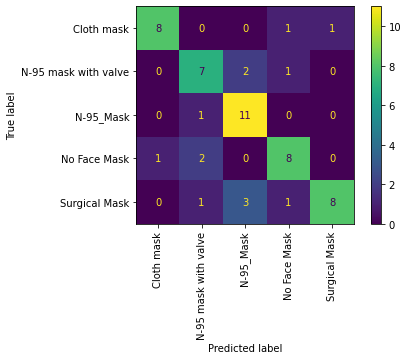

In [62]:
gen_model = torch.load(model_path)
test_image_path = r"drive/MyDrive/COMP6721_project/test_image/African_race"
image = ImageFolder(test_image_path)
test_image = FaceMaskDataset(image, test_transform)
test_data = DataLoader(test_image, 10)
test_loss , test_accuracy,l,p = Test(gen_model,test_data,device)

# Classification report and Confusion matrix for testing images
print(classification_report(l,p, target_names=target_names))
cm = confusion_matrix(l,p)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp.plot(xticks_rotation="vertical")
plt.show()

                      precision    recall  f1-score   support

          Cloth mask       0.83      0.50      0.62        10
N-95 mask with valve       0.67      0.60      0.63        10
           N-95_Mask       0.50      0.64      0.56        11
        No Face Mask       0.67      0.80      0.73        10
       Surgical Mask       0.80      0.80      0.80        10

            accuracy                           0.67        51
           macro avg       0.69      0.67      0.67        51
        weighted avg       0.69      0.67      0.67        51



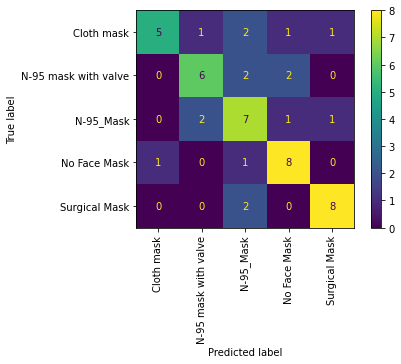

In [63]:
gen_model = torch.load(model_path)
test_image_path = r"drive/MyDrive/COMP6721_project/test_image/Whitish_race"
image = ImageFolder(test_image_path)
test_image = FaceMaskDataset(image, test_transform)
test_data = DataLoader(test_image, 10)
test_loss , test_accuracy,l,p = Test(gen_model,test_data,device)

# Classification report and Confusion matrix for testing images
print(classification_report(l,p, target_names=target_names))
cm = confusion_matrix(l,p)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp.plot(xticks_rotation="vertical")
plt.show()